# Домашнее задание 5

Ссылка на семинар: https://colab.research.google.com/drive/1_G8kdmhtokmAUeMsSrl1IKqIs3_FEbeK?usp=sharing

Не забудьте поставить видеокарту в качестве аппаратного ускорителя :)

### Сохранение и загрузка

[3 балла] 

Сделайте сохранение моделей после обучения (в формате .pth). В случае маленьких сетей на маленьких данных в этом нет необходимости, но в других случаях можно сохранять версию модели (checkpoint) каждые несколько (к примеру 5) эпох. Сделайте и протестируйте загрузку моделей для задачи классификации рукописных цифр.

### Сверточная сеть на CIFAR-10

[5 баллов]

Решите задачу классификации на другом датасете - CIFAR-10 https://en.wikipedia.org/wiki/CIFAR-10
В примерах к Pytorch есть полное решение этой задачи, но попробуйте придумать его самостоятельно. Этот датасет отличается от mnist тем, что изображения в нём имеют размер не 28x28, а 32x32x3, то есть они трёхканальные, "цветные". Для того, чтобы сеть заработала и начала хотя бы как-то учиться, нужно сделать так, чтобы размеры (shapes) тензоров на выходе предыдущего слоя совпадали с размером тензоров на входе следующего слоя.

### Классификация на своих картинках

[6 баллов]

Запустите распознавание цифр на самостоятельно записанных данных. Можно использовать фотографию листочка, можно просто нарисовать их в пейнте. Чтобы все заработало, нужнро во-первых помнить, что сеть, созданная для работы с mnist, принимает на вход одноканальные картинки 28x28, а во-вторых учесть, что границы цифр в обучающих данных не резкие, в процессе их подготовки был применён антиалеасинг.

### Загадка

Доп.задача 1 [5 баллов]

Найдите, почему при обучении свёрточной сети (Conv_net в семинаре) test loss всё время меньше train loss-а. Напишите, почему так получается, исправьте ошибку, если она есть. Обратите внимание, что при обучении Simple_net такого не наблюдается.

In [1]:
from __future__ import print_function
import argparse
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

#Batch preprocessing

In [2]:
batch_size = 100
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/cifar-10-python.tar.gz to ../data


#Alternative batch preprocessing

In [ ]:
#@title

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=100,
                                          shuffle=True, 
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
test_loader = torch.utils.data.DataLoader(testset, 
                                         batch_size=100,
                                         shuffle=False, 
                                         num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Network classes

In [17]:
class Net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1,padding=1)
        self.act1=nn.ReLU()
        self.conv2 = nn.Conv2d(6, 12, 3, 1,padding=1)
        self.max_pool2=nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        #Flatten in forward function
        self.fc1 = nn.Linear(16*16*12, 100)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(100, 10)
        #self.act3 = nn.Softmax(dim=1)

    def forward(self, x):
        #torch.Size([batch_size, 3, 32, 32])
        x = self.conv1(x)
        #torch.Size([batch_size, 30, 32, 32])
        x = self.act1(x)
        x = self.conv2(x)
        #torch.Size([batch_size,60,32,32])
        x = self.max_pool2(x)
        #torch.Size([batch_size, 60, 16, 16])
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        #torch.Size([batch_size, 15360])
        x = self.fc1(x)
        #torch.Size([batch_size, 100])
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([batch_size, 10])
        x = F.log_softmax(x,dim=1)
        return x
    
    #Using Softmax only for probability predictions
    #In training we don't really need Softmax, faster not to use it
    def inference(self,x):
        x = self.forward(x)
        x = self.act3(x)
        return x








class Le_net(nn.Module):
    def __init__(self):
        super(Le_net, self).__init__()

        #in 3*32*32
        self.conv1 = nn.Conv2d(3, 3, 3)
        self.conv2 = nn.Conv2d(3,6,3)
        self.act1=nn.ReLU()
        self.max_pool1=nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.act2 = nn.ReLU()
        #out 6*14*14

        #in 6*14*14
        self.conv3 = nn.Conv2d(6, 6, 3)
        self.conv4 = nn.Conv2d(6, 16, 3)
        self.act3 = nn.ReLU()
        self.max_pool2=nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.25)
        self.act4 = nn.ReLU()
        #out 16*5*5

        #Flatten in forward function
        self.fc1 = nn.Linear(16*5*5, 100)
        self.act5 = nn.ReLU()
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(100, 10)
        #last activation in forward function

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.act1(x)
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.act3(x)
        x = self.max_pool2(x)
        x = self.dropout2(x)
        x = self.act4(x)

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.act5(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x

#Training procedure

In [6]:
def train(model, train_dataset, epochs, optimizer):
    model.train()
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for data,target in train_dataset:
            data=data.to(device)
            target=target.to(device)
            optimizer.zero_grad()   # zero the gradient buffers
            output = model.forward(data)
            
            loss = F.nll_loss(output, target)
            loss.backward()
            loss_samples.append(loss.data.cpu().numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

#Test procedure

In [7]:
def test(model, device, test_loader):
    model.eval()
    loss=0
    accuracy = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model.forward(data)
            loss+= F.nll_loss(output,target)
            pred = output.argmax(dim=1, keepdim=True)
            target = target.view_as(pred)
            for i,single_pred in enumerate(pred):
                if single_pred == target[i]:
                    correct+= 1
            total += len(pred)
    loss = loss/len(test_loader)
    accuracy = correct / total
    
    print(loss)
    print('\n Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, total, 100. * accuracy))

#Alternative test (beta)

In [32]:
#@title
def test(model, device, test_loader):
    test_loss_history = []
    model.eval()
    for data,target in test_loader:
        data, target = data.to(device), target.to(device)
        pred = model.forward(data)
        test_loss_history.append(F.nll_loss(pred, target).data.cpu())
        accuracy = (pred.argmax(dim=1) == target).float().mean().data.cpu()
        print(accuracy)

#New neral network from class
####you can restart to refresh weights to random

In [18]:
device = torch.device("cuda" if use_cuda else "cpu")
net = Le_net().to(device)

#Main loop

######Try your luck!

Epoch        0 Loss: 1.9692185392379762
Epoch        1 Loss: 1.7586684112548827
Epoch        2 Loss: 1.7060069205760955
Epoch        3 Loss: 1.6684755930900574
Epoch        4 Loss: 1.6494665515422822
Epoch        5 Loss: 1.6313079736232758
Epoch        6 Loss: 1.6126668853759765
Epoch        7 Loss: 1.6020069947242737
Epoch        8 Loss: 1.5906036787033082
Epoch        9 Loss: 1.577273516178131


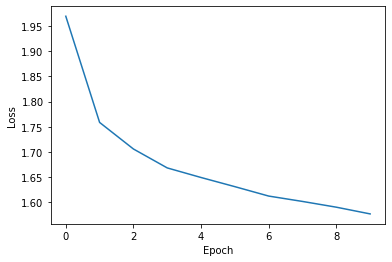

tensor(1.4045, device='cuda:0')

 Accuracy: 5025/10000 (50%)

Epoch        0 Loss: 1.5698617942333222
Epoch        1 Loss: 1.5645761210918427
Epoch        2 Loss: 1.5503649508953095
Epoch        3 Loss: 1.5498690671920776
Epoch        4 Loss: 1.5433621535301207
Epoch        5 Loss: 1.5324081995487213
Epoch        6 Loss: 1.5273836073875426
Epoch        7 Loss: 1.5247396428585052
Epoch        8 Loss: 1.517415755033493
Epoch        9 Loss: 1.5203482525348664


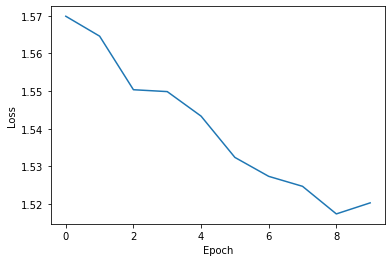

tensor(1.3218, device='cuda:0')

 Accuracy: 5373/10000 (54%)

Epoch        0 Loss: 1.508543305158615
Epoch        1 Loss: 1.511049569606781
Epoch        2 Loss: 1.5023932240009308
Epoch        3 Loss: 1.502752381324768
Epoch        4 Loss: 1.501410174846649
Epoch        5 Loss: 1.4947423107624054
Epoch        6 Loss: 1.4948405203819275
Epoch        7 Loss: 1.488862777709961
Epoch        8 Loss: 1.4855152432918548
Epoch        9 Loss: 1.4901337637901306


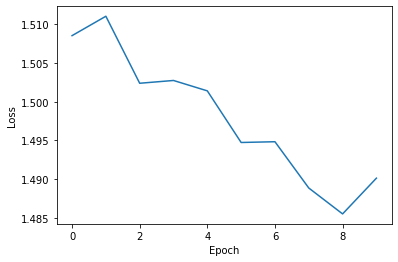

tensor(1.2940, device='cuda:0')

 Accuracy: 5530/10000 (55%)



In [19]:
#Main loop train epochs_train times and test once and
#repeat it train_cycles times
train_cycles=3
epochs_train=10
lr=0.001
#Main loop
for i in range(train_cycles):
    train(model=net, train_dataset=train_loader, epochs=epochs_train, optimizer=optim.Adam(net.parameters(), lr=lr))
    test(model=net,device=device,test_loader=test_loader)